# GETTING READY

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/deep-voice-deepfake-

In [2]:
!pip install librosa
!pip install pydub

In [3]:
import os
import librosa
from pydub import AudioSegment
import random

dataset_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO"
augmented_dataset_path = "/kaggle/working/SPLITTED"

# bikin directory untuk data audio
os.makedirs(augmented_dataset_path, exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "FAKE"), exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "REAL"), exist_ok=True)

def split_audio_file(file_path, output_dir, segment_length=10):
    audio = AudioSegment.from_wav(file_path)
    duration = audio.duration_seconds
    segment_length_ms = segment_length * 1000  # dalam milliseconds

    segments = []
    for i in range(0, len(audio), segment_length_ms):
        segment = audio[i:i + segment_length_ms]
        segment_file_name = f"{os.path.splitext(os.path.basename(file_path))[0]}_part{i // segment_length_ms}.wav"
        segment_path = os.path.join(output_dir, segment_file_name)
        segment.export(segment_path, format="wav")
        segments.append(segment_path)
    return segments

# split audio menjadi sample" 10 detik agar data semakin banyak
real_samples_path = os.path.join(dataset_path, "REAL")
for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "REAL")
    split_audio_file(file_path, output_dir)

fake_samples_path = os.path.join(dataset_path, "FAKE")
fake_segments = []
for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "FAKE")
    fake_segments.extend(split_audio_file(file_path, output_dir))

# pilih data AI voice secara random sebanyak data real yang ada agar seimbang
selected_fake_segments = random.sample(fake_segments, len(os.listdir("/kaggle/working/SPLITTED/REAL")))

# bikin dan isi directory untuk data AI voice yang terpilih
selected_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")
os.makedirs(selected_fake_path, exist_ok=True)

for segment in selected_fake_segments:
    segment_file_name = os.path.basename(segment)
    os.rename(segment, os.path.join(selected_fake_path, segment_file_name))

# NAIVE BAYES

In [4]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# extract fitur MFCC
def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

fake_samples_path = "/kaggle/working/SPLITTED/SELECTED_FAKE"
real_samples_path = "/kaggle/working/SPLITTED/REAL"

features = []
labels = []

# ambil data AI voice
for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(0)  # Label 0 for fake
        
# ambil data real voice
for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(1)  # Label 1 for real

# split data menjadi training dan testing
X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# inisialisasi model
model = GaussianNB()

# training model
model.fit(X_train, y_train)

# simpan prediksi model
y_pred = model.predict(X_test)

# evaluasi model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


Accuracy: 0.8562091503267973
Precision: 0.9090909090909091
Recall: 0.7894736842105263
F1-score: 0.8450704225352113


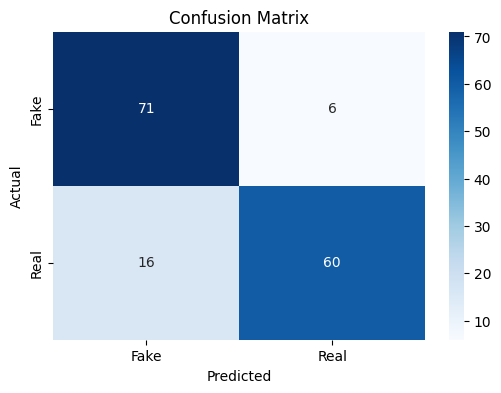

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# print confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [6]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87        77
           1       0.91      0.79      0.85        76

    accuracy                           0.86       153
   macro avg       0.86      0.86      0.86       153
weighted avg       0.86      0.86      0.86       153



# KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
# panggil model KNN
knn = KNeighborsClassifier()

# training model KNN
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# evaluasi model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.9738562091503268
Precision: 0.9736842105263158
Recall: 0.9736842105263158
F1-score: 0.9736842105263158


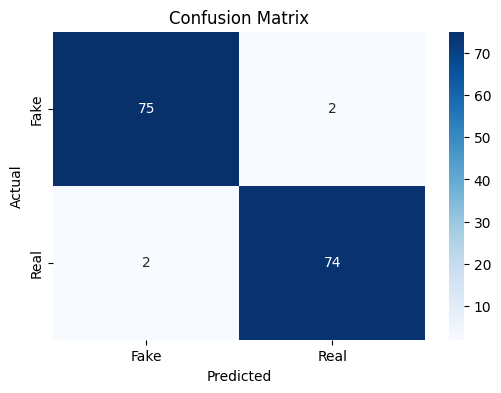

In [9]:
# print confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        77
           1       0.97      0.97      0.97        76

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



# SVC

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import soundfile as sf
import random

In [12]:
# inisialisasi selector untuk menentukan K terbaik
selector = SelectKBest(f_classif, k='all')
X_new = selector.fit_transform(X_train, y_train)

In [13]:
# panggil parameter yang dibutuhkan
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('svm', SVC(probability=True))
])

# inisialisasi parameter
param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf']
}

# memilih parameter yang terbaik
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'selector__k': 11, 'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best score: 0.9950819672131148


In [14]:
# buat prediksi
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [15]:
# evaluasi model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.9934640522875817
Precision: 1.0
Recall: 0.9868421052631579
F1-score: 0.9933774834437086


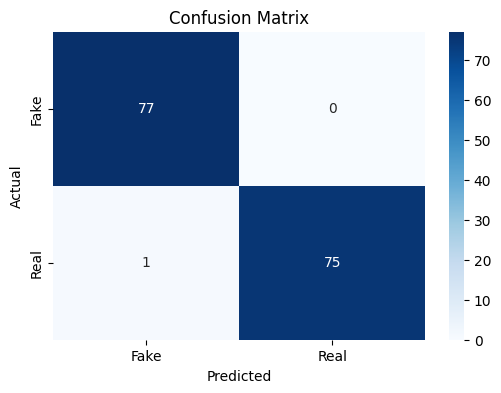

In [16]:
# print confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        77
           1       1.00      0.99      0.99        76

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153

